In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import geopandas as gpd
import albumentations as albu
import zipfile
from shapely.geometry import MultiPolygon, shape, transform, box
from pyproj import Proj, transform as coord_transform
import fiona
import rasterio
import json
from matplotlib.colors import Normalize

In [ ]:
tif_path = '../../../../net/projects/cmap/data/GIBI-images'

image_path = tif_path + '/../KC-images/m_4108814_ne_16_060_20210928.tif'
    # if the image does not exist, skip this annotation
if image_path is None or not os.path.isfile(image_path):
    print(f"No file {image_path} found -- skipping this annotation")

src = rasterio.open(image_path)

selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"
layers = fiona.listlayers(gdb_path)

gdf = gpd.read_file(gdb_path, layer=selected_layer)

bbox = box(*src.bounds)
geo_frame = gdf.copy()
#print(geo_frame.geometry)
geo_frame = geo_frame.to_crs(src.crs)
#print(geo_frame.geometry)
print(bbox)
geo_frame = geo_frame.drop(geo_frame[~geo_frame["geometry"].intersects(bbox)].index)
print("Len Geo", len(geo_frame.index))
"""
It takes a GeoDataFrame that contains the annotation information
and converts each annotated picture to a mask and saves it in the directory

Parameters:
    geo_frame: GeoDataFrame that contains the information for the annotations

Returns: a list that stores the paths to all the masks
"""
#print(f"processing {geo_frame}")

mask_paths = []
image_paths = []
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

temp_mask = np.zeros(img.shape[:2], np.uint8)

# Iterate through each row in the GeoDataFrame
for index, row in geo_frame[:3].iterrows():
    img_annotation_chunks = row['geometry'].geoms[0].exterior.coords

    #image_path = tif_path + '/0.tif'
    # if the image does not exist, skip this annotation
    #if image_path is None or not os.path.isfile(image_path):
    #    print(f"No file {image_path} found -- skipping this annotation")
    #    continue

    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    mask_path = os.path.abspath(image_path)#.replace('0.tif', '0mask.tif')
    head, tail = os.path.splitext(mask_path)
    mask_path = head + "_mask" + tail

    mask = np.zeros(img.shape[:2], np.uint8)
    #mask = mask.cx[bbox.bounds[0]:bbox.bounds[2], bbox.bounds[1]:bbox.bounds[3]]
    print(bbox.bounds)
    min_x = int(bbox.bounds[0])
    min_y = int(bbox.bounds[1]) #This will create lots of inaccuracy at the magnified level
    #for geom in img_annotation_chunks:
    coords = np.array(img_annotation_chunks)
    coords = coords.astype(np.int32)
    #coords = coords - bbox.min(axis=0)
    coords[:, 0] -= min_x
    coords[:, 1] -= min_y
    print("CoorLen",len(coords))
    
    for coor in coords:
        plt.scatter(coor[0], coor[1])
    #plt.xlim(390725.4, 396575.4 )
    #plt.ylim(4629469.2, 4637029.8)
    plt.show()

    #temp_mask = np.zeros(img.shape[:2], np.uint8)
    
    
    print("TShape:", temp_mask.shape)
    
    plt.plot(coords[:, 0], coords[:, 1], 'ro')  # Red dots for input coordinates
    plt.title("Input Coordinates")
    plt.show()

    # Use coords directly in cv2.fillPoly
    cv2.fillPoly(temp_mask, [coords], (255, 0, 0))

    # Visualize the temporary mask
    plt.imshow(temp_mask, cmap='gray')
    plt.title("Temporary Mask")
    plt.show()
    
    print("TempSum", temp_mask.sum())
    print("Coords Type:", type(coords))
    print("Coords Shape:", coords.shape)
    print("Temp Mask Type:", type(temp_mask))
    print("Temp Mask Sum:", temp_mask.sum())

    # Visualize the temporary mask
    plt.imshow(temp_mask, cmap='gray')
    plt.title("Temporary Mask")
    plt.show()
    
    mask = cv2.bitwise_or(mask, temp_mask)
    
    print("Mask type:", type(mask))
    print("MaskSum:", mask.sum())
    
img[:, :] = 255
img = cv2.bitwise_and(img, img, mask=mask)
    
print("IMG type:", type(img))
print("IMGSum:", img.sum())
    
os.makedirs(os.path.dirname(mask_path), exist_ok=True)
cv2.imwrite(mask_path, img)

#try:
#    change_permission(mask_path, 0o770)
#except NotOwnerError as e:
#    print(e)

mask_paths.append(mask_path)
image_paths.append(image_path)

mask_paths

In [32]:
tif_path = '../../../../net/projects/cmap/data/GIBI-images'
image_path = tif_path + '/../KC-images/m_4108814_ne_16_060_20210928.tif'

# if the image does not exist, skip this annotation
if image_path is None or not os.path.isfile(image_path):
    print(f"No file {image_path} found -- skipping this annotation")

src = rasterio.open(image_path)

selected_layer = 'WTR_Countywide_Stormwater_Storage'
gdb_path = "../data/KC_StormwaterDataJan2024.gdb"
layers = fiona.listlayers(gdb_path)

gdf = gpd.read_file(gdb_path, layer=selected_layer)

bbox = box(*src.bounds)
geo_frame = gdf.copy()
geo_frame = geo_frame.to_crs(src.crs)
print(bbox)
geo_frame = geo_frame.drop(geo_frame[~geo_frame["geometry"].intersects(bbox)].index)
print("Len Geo", len(geo_frame.index))

mask_paths = []
image_paths = []
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
temp_mask = np.zeros(img.shape[:2], np.uint8)

# Get the initial mask outside the loop
mask = np.zeros(img.shape[:2], np.uint8)

min_x = int(bbox.bounds[0])
min_y = int(bbox.bounds[1])

# Iterate through each row in the GeoDataFrame
for index, row in geo_frame[:10].iterrows():
    img_annotation_chunks = row['geometry'].geoms[0].exterior.coords

    coords = np.array(img_annotation_chunks)
    coords = coords.astype(np.int32)
    coords[:, 0] -= min_x
    coords[:, 1] -= min_y
    

    cv2.fillPoly(temp_mask, [coords], (255, 0, 0))


    print("TempSum", temp_mask.sum())

    mask = cv2.bitwise_or(mask, temp_mask)

print("Mask type:", type(mask))
print("MaskSum:", mask.sum())

img[:, :] = 255
img = cv2.bitwise_and(img, img, mask=mask)

print("IMG type:", type(img))
print("IMGSum:", img.sum())

# Move the directory creation and image writing outside the loop
os.makedirs(os.path.dirname(mask_path), exist_ok=True)
cv2.imwrite(mask_path, img)

mask_paths.append(mask_path)
image_paths.append(image_path)

mask_paths


POLYGON ((396575.4 4629469.2, 396575.4 4637029.8, 390725.4 4637029.8, 390725.4 4629469.2, 396575.4 4629469.2))
Len Geo 227
TempSum 225675
TempSum 801465
TempSum 1543005
TempSum 2226405
TempSum 2629560
TempSum 3588360
TempSum 6557070
TempSum 6723330
TempSum 6885765
TempSum 14898375
Mask type: <class 'numpy.ndarray'>
MaskSum: 14898375
IMG type: <class 'numpy.ndarray'>
IMGSum: 14898375


['/net/projects/cmap/data/KC-images/m_4108814_ne_16_060_20210928_mask.tif']

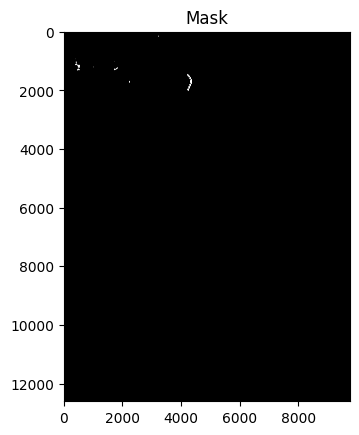

In [35]:
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

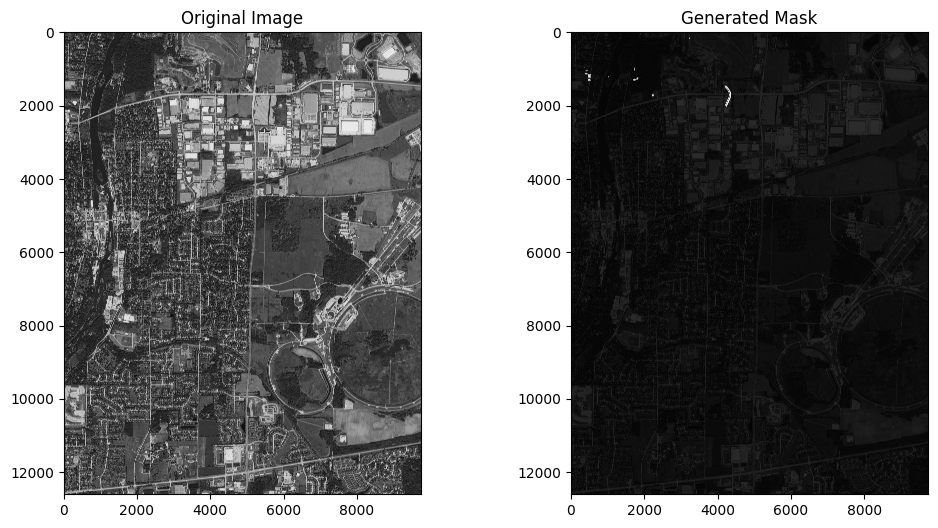

In [36]:
# Function to plot images with masks
def plot_images_with_masks(original_image, mask, title_original="Original Image", title_mask="Generated Mask"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot original image
    ax1.imshow(original_image, cmap='gray')
    ax1.set_title(title_original)
    #ax1.axis('off')

    # Plot mask overlaid on the original image
    masked_image = cv2.addWeighted(original_image, 0.2, mask, 0.8, 0)
    ax2.imshow(masked_image, cmap='gray')
    ax2.set_title(title_mask)
    #ax2.axis('off')

    plt.show()

# Load the original image and the generated mask
original_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
generated_mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

# Plot the images with masks
plot_images_with_masks(original_image, generated_mask)